# Setup - defining parameters that probably don't need to be changed

In [1]:

############Centroiding Parametesr###############

#thresholds for spot detection (*std)
findSigma=50     #sigma of threshold for finding spots
centSigma=15     #sigma of threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10    #size of box for finding spots
boxCent=6     #size of box for centroiding
nmin=10       #minimum number of acceptable pixels in a spot
nmax=90       #maximum number of acceptable pixels in a spot
maxIt=20      #maximum number of iterations for centroiding

#set to non zero to override automatic fwhm determination. 
fwhmx=0
fwhmy=0

sigmaThresh = 4
threshFact = 2

##############Various Flags####################

#inter = 1 for notebook, 0 for scripts, cenFlag='local' for local, 'db' to read from database
inter=1
cenFlag='local'
#cenFlag='db'

#dataSource - set to 'pinhole' for pinhole mask, 'taichung' for lab data. 

dataType='pinhole'

#conifguration for rotator center

config="oct18"

#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients
from importlib import reload  #for debugging purposes

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.plotRoutines as visplot
except:
    import plotRoutines as visplot


# connect to database

In [3]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    

# parameters that change for each run

In [19]:

#set frame ID minimum and maximum values (inclusive)

frameId1=8396
frameId2=8421

#any frames to skip (bad data, etc)
frameSkip=[]   

#source directory data files in local mode
#sourceDir="/Volumes/Vaal/Commissioning Run/2018-10-25/"
sourceDir="/Users/karr/ics_mcsActor/python/mcsActor/Visualization/Day1/"

#subtitle for plots - first frame ID plus tag
stitle=" ["+str(frameId1).zfill(4)+"] (rotation)"

fPref="PFSC"
#get various file name inforamtion
files,prefix,centroidFile,frameIDs=vis.getFileNames(frameId1,frameId2,frameSkip,sourceDir,fPref,dataType)

nfiles=len(files)
print("Read "+str(len(files))+" files names. First = "+str(frameId1)+" Last="+str(frameId2))
print("prefix="+prefix+" centroidFile="+centroidFile)


Read 26 files names. First = 8396 Last=8421
prefix=see_08396_08421 centroidFile=see_08396_08421_centroids.dat


# calculate threshold values and region (once per config)

Thresholds= 11348.915060854086 4537.358986343017
Boundaries of region (x1,x2,y1,y2):  19 5770 1001 6444


<IPython.core.display.Javascript object>


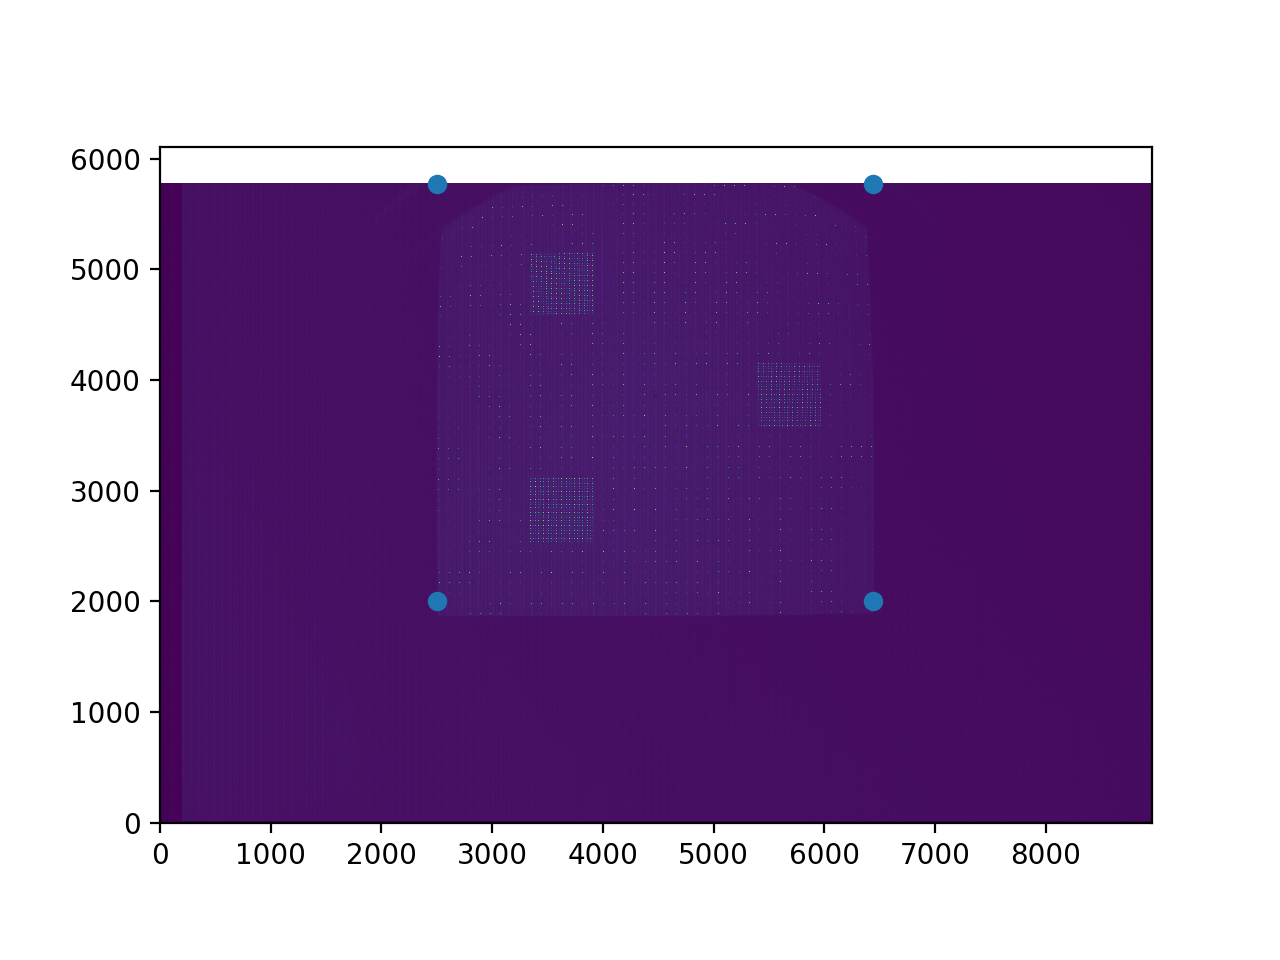

In [20]:
#not needed if pulling from DB
reload(vis)
reload(mcs)

image=vis.getImage(files[0])
findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'calib',sigmaThresh,threshFact,findSigma,centSigma)
        
print("Thresholds=",findThresh,centThresh)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])

#yrange[0]=2786
#a=mcs.getManualThresh(image,xrange,yrange,sigmaThresh)
#findThresh=a.mean()+a.std()*sigmaFind
#centThresh=a.mean()+a.std()*sigmaCent

yrange[0]=2503
xrange[0]=2000
yrange[0]=2503
xrange[0]=2000
visplot.checkThreshold(image,xrange,yrange)
a=mcs.getManualThresh(image,xrange,yrange,sigmaThresh)
findThresh=a.mean()+a.std()*findSigma
centThresh=a.mean()+a.std()*centSigma


# Do the centroiding for a set of database, either locally or retrieve from DB


Centroiding with Parameters:  8076.4840457678365 3676.8190712679852 0 0 10 6 10 90 20
26 Frames. Centroiding 1: 3541, 2: 3540, 3: 3507, 4: 3507, 5: 3541, 6: 3541, 7: 3542, 8: 3542, 9: 3541, 10: 3541, 11: 3499, 12: 3499, 13: 3511, 14: 3513, 15: 3497, 16: 3498, 17: 3540, 18: 3540, 19: 3541, 20: 3540, 21: 3540, 22: 3540, 23: 3507, 24: 3507, 25: 3540, 26: 3539, 


<IPython.core.display.Javascript object>


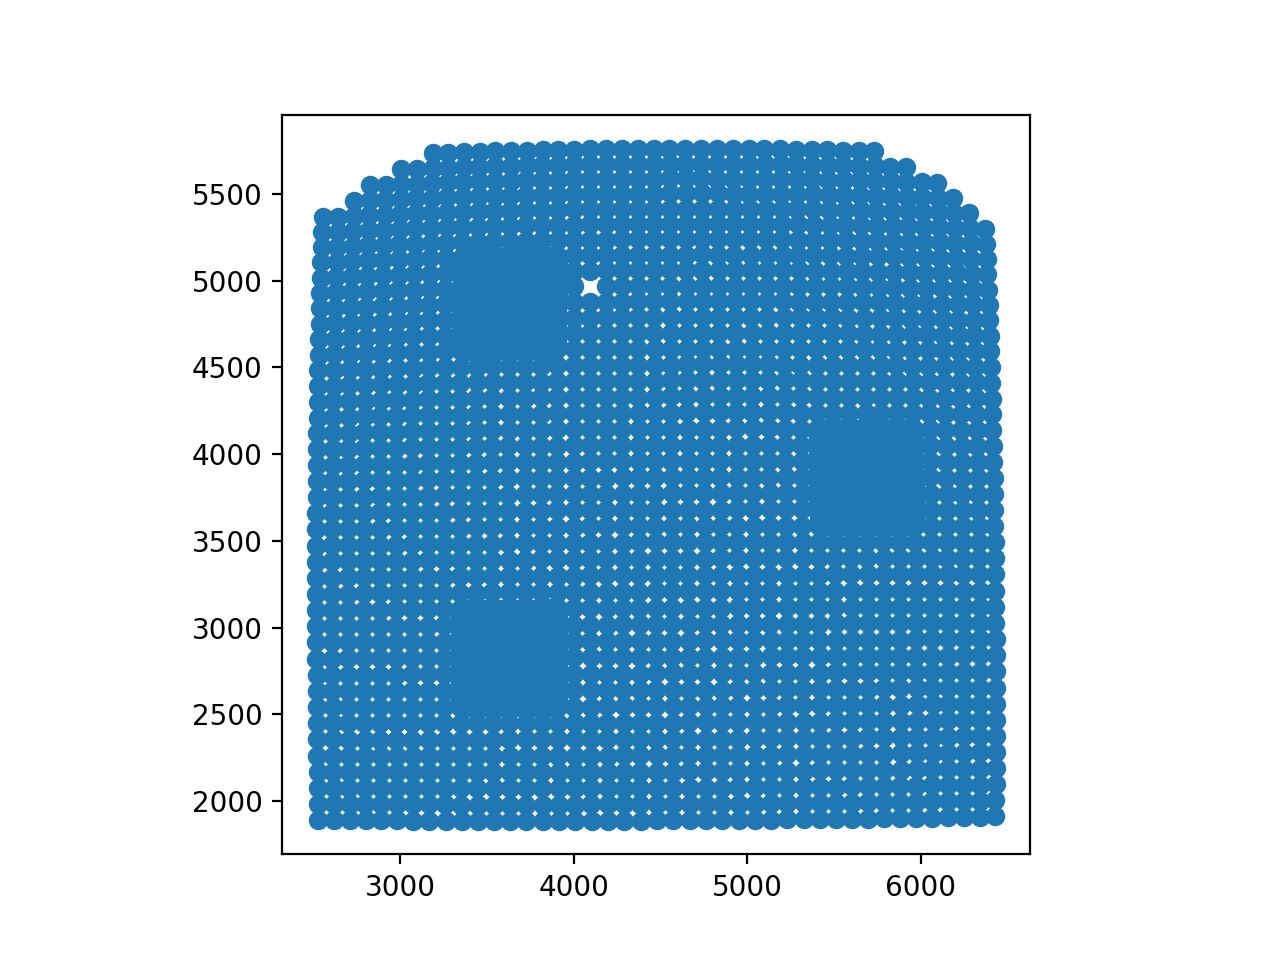

In [22]:
reload(vis)
reload(mcs)
reload(visplot)


#set redo=1 to recalculate values, redo=0 to read from files    
redo=1

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):

    if(redo==1):
        print("Centroiding with Parameters: ",findThresh,centThresh,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        vis.getAllCentroids(files,centroidFile,findThresh*0.8,centThresh,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt,frameIDs)
        centroids=np.loadtxt(centroidFile)
    else:
        print("Loading Centroids from Local File.")
        centroids=np.loadtxt(centroidFile)
#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=fps.getCentroidsDB(conn,frameIDs)        
        
#extract the first set of centroids for summary plot
ind=np.where(centroids[:,0]==frameId1)
xlast=centroids[ind,2].ravel()
ylast=centroids[ind,3].ravel()
         
visplot.checkCentroids(xlast,ylast,1,prefix,inter)


In [23]:

reload(mcs)

xCorner=[]
yCorner=[]

for i in frameIDs:
    ind=np.where(centroids[:,0]==i)
    x=centroids[ind,2].ravel()
    y=centroids[ind,3].ravel()

    x0,x1,y0,y1=mcs.getCorners(x,y)
    xCorner.append(x0)
    yCorner.append(y0)

xCorner=np.array(xCorner)
yCorner=np.array(yCorner)



<IPython.core.display.Javascript object>


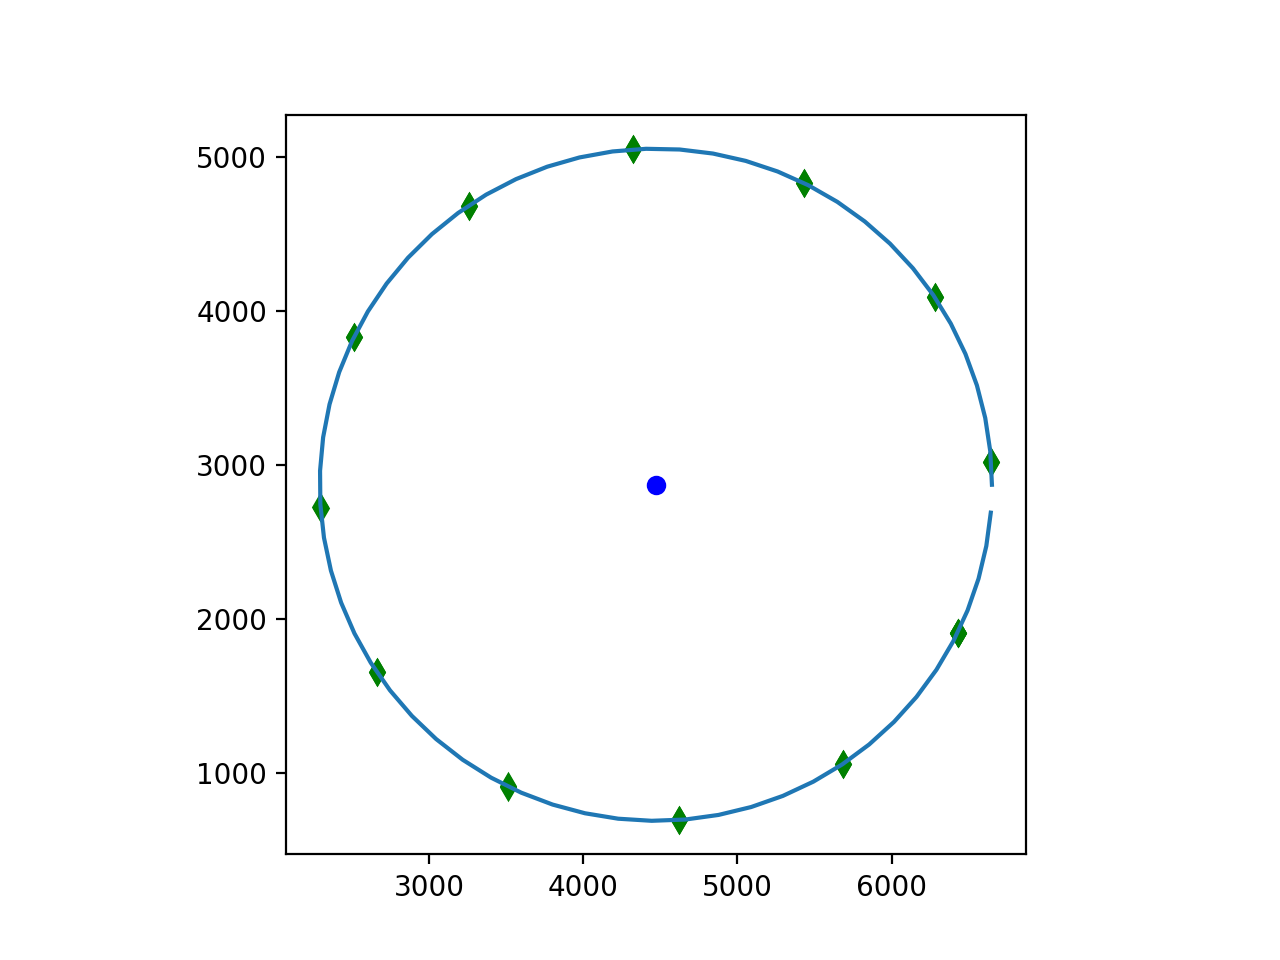

4470.8057710389685 2872.764283368246 2180.965698409823


In [24]:
reload(mcs)
fig,ax=plt.subplots()
ax.plot(xCorner,yCorner,'dg')

coords=[xCorner,yCorner]
xc,yc,r,_=fps.least_squares_circle(xCorner,yCorner)
print(xc,yc,r)

xval=[]
yval=[]
for theta in np.arange(0,2*np.pi,0.1):
    xval.append(r*np.cos(theta)+xc)
    yval.append(r*np.sin(theta)+yc)
    
ax.plot(xval,yval)
ax.plot([xc],[yc],'ob')
ax.set_aspect('equal')
plt.show()
    


In [10]:
print('first',xc,yc)

4769.8932952830655 2941.1381113089324


In [16]:
print('second',xc,yc)

second 4482.49826206282 2885.541212769187


In [13]:
print('third',xc,yc)

third 4470.8057710389685 2872.764283368246


In [9]:
print('rot90',xc,yc)

rot90 4467.989450949258 2865.2707535177565


In [17]:
print('rot60',xc,yc)

rot60 4467.615159472747 2863.4521994953448


In [23]:
print('rot45',xc,yc)

rot45 4470.676457248728 2850.533521829027


In [13]:
nbins=30
inter=0
reload(visplot)
for f in frameIDs:
    ind=np.where(centroids[:,0]==int(f))
    prefix=str(int(f))
    x=centroids[ind,2].ravel()
    y=centroids[ind,3].ravel()
    fx=centroids[ind,4].ravel()
    fy=centroids[ind,5].ravel()
    peak=centroids[ind,6].ravel()
    
    plotRange=[1,6]
    visplot.pairPlot(x,y,fx,fx,plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
    plotRange=[1,6]
    visplot.pairPlot(x,y,fy,fy,plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)

    #peak values
    plotRange=[peak.min(),peak.max()]
    visplot.pairPlot(x,y,peak,peak,plotRange,"Peak",prefix,"_peak","Peak","",nbins,inter,stitle=stitle)
    inter=1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: zero-size array to reduction operation minimum which has no identity

In [59]:
vv=np.arange(10)
fig,ax=plt.subplots()
bins=np.arange(1,7,0.2)
ax.hist(fx,)
plt.show()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [25]:
print(xc,yc)

4470.8057710389685 2872.764283368246
